In [1]:
import numpy as np
from torch import nn
from tqdm import tqdm
import torch.nn.functional as F
from torchvision import datasets, models

import torch
from torchvision import datasets, transforms

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Downloading & Loading Fashion-MNIST

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

In [4]:
classes = np.unique(trainset.targets.numpy())
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
# Creating Mapping for source and payload images

mapping = {key: key + 1 for key in np.arange(0, len(classes), 2)}
print('Mapping : '.format(mapping))

# Converting tensors to numpy

train_x = trainset.data.numpy()
train_y = trainset.targets.numpy()

Mapping : 


In [6]:
# Creating source and payload masks from labels

source_mask = np.in1d(train_y, list(mapping.keys()))
payload_mask = np.logical_not(source_mask)

print(np.sum(source_mask), np.sum(payload_mask))

# Creating source and payload data
source_data, source_labels = train_x[source_mask], train_y[source_mask]
payload_data, payload_labels = train_x[payload_mask], train_y[payload_mask]

30000 30000


In [7]:
np.unique(train_y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

# Visualizing Data

In [8]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


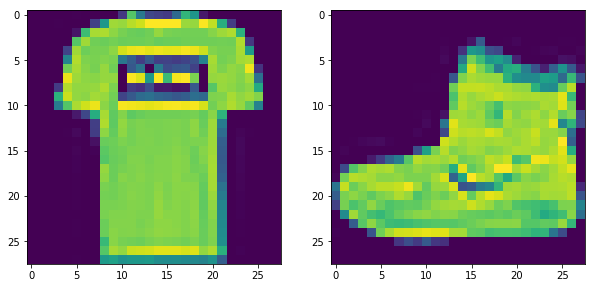

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(source_data[0])
plt.subplot(1,2,2)
plt.imshow(payload_data[0])

# Train Val Test splitting

In [10]:
split_size = 0.8

total_data = source_data.shape[0]

train_size = int(total_data * split_size)
source_train = source_data[:train_size] # , source_labels[:train_size]
payload_train = payload_data[:train_size] # , payload_labels[:train_size]

remaining_source, remaining_payload = source_data[train_size:], payload_data[train_size:]
half_size = int(remaining_source.shape[0] / 2.)

source_val, payload_val = remaining_source[:half_size], remaining_payload[:half_size]
source_test, payload_test = remaining_source[half_size:], remaining_payload[half_size:]

print(source_train.shape, source_val.shape, source_test.shape)
print(payload_train.shape, payload_val.shape, payload_test.shape)

(24000, 28, 28) (3000, 28, 28) (3000, 28, 28)
(24000, 28, 28) (3000, 28, 28) (3000, 28, 28)


# Helper Function

In [32]:
import numpy 
import math
import cv2

def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

# Declaring Architecture

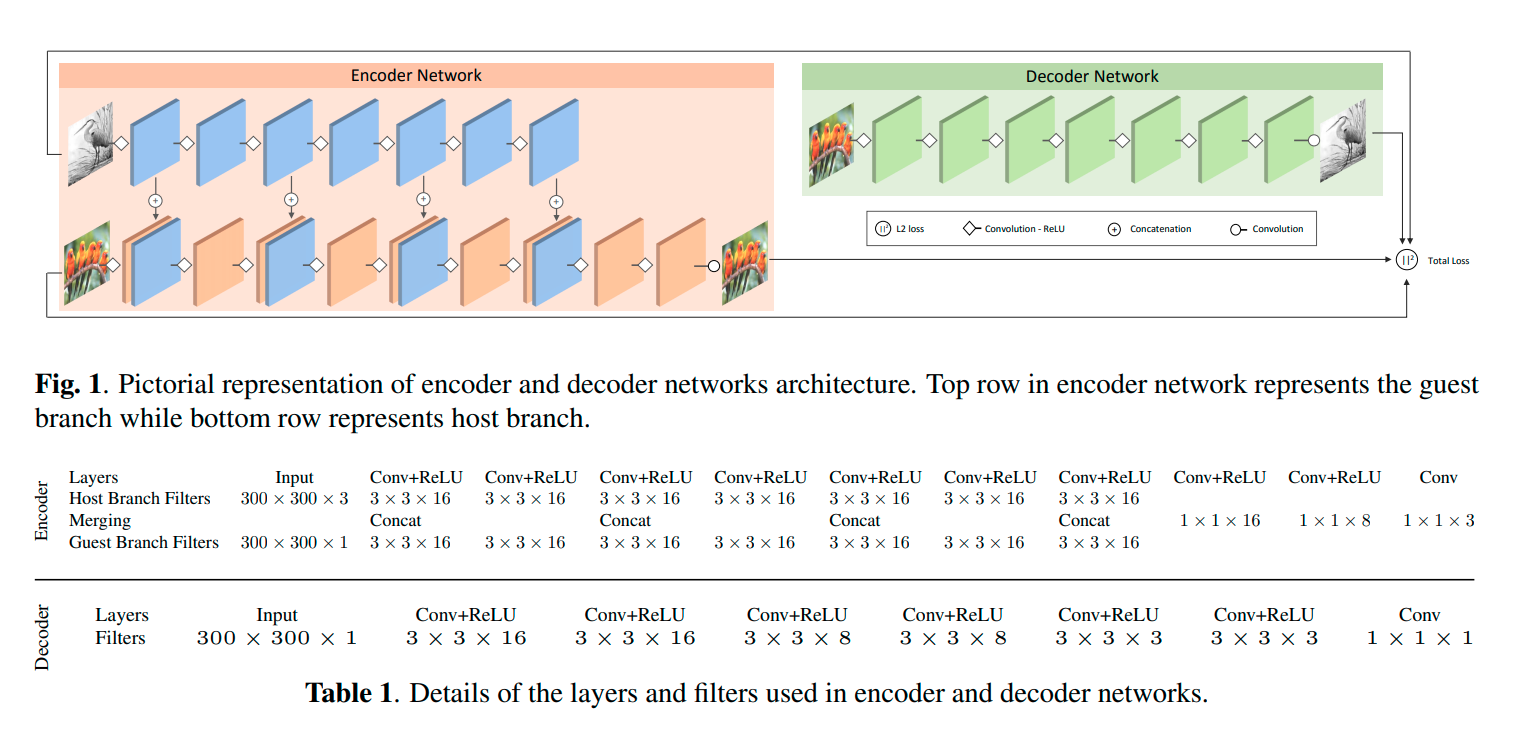

In [11]:
class StegNet(nn.Module):
    def __init__(self):
        super(StegNet, self).__init__()
        self.encoder_source, self.encoder_payload = self.define_encoder()
        self.decoder = self.define_decoder()
        
    def define_encoder(self):
        encoder_payload, encoder_source = [], []
        
        # layer1
        self.encoder_payload_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.encoder_source_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        
        # layer2
        self.encoder_payload_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        
        # layer3
        self.encoder_payload_3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        
        # layer4
        self.encoder_payload_4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_4 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        
        # layer5
        self.encoder_payload_5 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_5 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        
        # layer6
        self.encoder_payload_6 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_6 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        
        # layer7
        self.encoder_payload_7 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_7 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        
        # layer8
        self.encoder_payload_8 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_8 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        
        # layer9
        self.encoder_source_9 = nn.Conv2d(32, 16, kernel_size=1)
        
        #layer10
        self.encoder_source_10 = nn.Conv2d(16, 8, kernel_size=1)
        
        #layer11
        self.encoder_source_11 = nn.Conv2d(8, 1, kernel_size=1)
        
        return encoder_source,  encoder_payload
    
    def define_decoder(self):
        decoder_layers = []
        
        self.decoder_layers1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.decoder_layers2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        
        self.decoder_layers3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.decoder_layers4 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        
        self.decoder_layers5 = nn.Conv2d(8, 3, kernel_size=3, padding=1)
        self.decoder_layers6 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        
        self.decoder_layers7 = nn.Conv2d(3, 1, kernel_size=3, padding=1)
        
        return decoder_layers
    
    def forward(self, x):
        
        source, payload = x
        
        s = source.view((-1, 1, 28, 28))
        p = payload.view((-1, 1, 28, 28))
        
        # --------------------------- Encoder -------------------------
        # layer1
        p = F.relu(self.encoder_payload_1(p))
        s = F.relu(self.encoder_source_1(s))
        
        #layer2
        p = F.relu(self.encoder_payload_2(p))
        s = torch.cat((s, p), 1)
        s = F.relu(self.encoder_source_2(s))
        # layer3
        p = F.relu(self.encoder_payload_3(p))
        s = F.relu(self.encoder_source_3(s))
        
        #layer4
        p = F.relu(self.encoder_payload_4(p))
        s = torch.cat((s, p), 1)
        s = F.relu(self.encoder_source_4(s))
        
        # layer5
        p = F.relu(self.encoder_payload_5(p))
        s = F.relu(self.encoder_source_5(s))
        
        #layer6
        p = F.relu(self.encoder_payload_6(p))
        s = torch.cat((s, p), 1)
        s = F.relu(self.encoder_source_6(s))
        
        # layer7
        p = F.relu(self.encoder_payload_7(p))
        s = F.relu(self.encoder_source_7(s))
        
        #layer8
        p = F.relu(self.encoder_payload_8(p))
        s = torch.cat((s, p), 1)
        s = F.relu(self.encoder_source_8(s))
        
        #layer9
        s = F.relu(self.encoder_source_9(s))
        
        #layer10
        s = F.relu(self.encoder_source_10(s))
        
        #layer11
        encoder_output = self.encoder_source_11(s)
        
        # -------------------- Decoder --------------------------
        
        d = encoder_output.view(-1, 1, 28, 28)
        
        #layer1
        d = F.relu(self.decoder_layers1(d))
        #layer2
        d = F.relu(self.decoder_layers2(d))
        #layer3
        d = F.relu(self.decoder_layers3(d))
        #layer4
        d = F.relu(self.decoder_layers4(d))
        #layer5
        d = F.relu(self.decoder_layers5(d))
        #layer6
        d = F.relu(self.decoder_layers6(d))        
        #layer7
        decoder_output = self.decoder_layers7(d)
        
        return encoder_output, decoder_output
    
model = StegNet()
model

StegNet(
  (encoder_payload_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_6

In [18]:
model.cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

metric = nn.L1Loss()

# Training

In [19]:
epochs = 40

train_losses, val_losses = [], []
train_batch_size = 64
test_batch_size = 60
flat_image_size = 28*28
valid_loss_min = +np.inf

for epoch in range(epochs):
    model.train()
    train_loss = 0.
    total_batches = int(len(source_train) /train_batch_size)
    for idx in tqdm(range(total_batches)):
        
        start = idx * train_batch_size
        end = start + train_batch_size
        
        s, p = source_train[start: end], payload_train[start: end]
        s, p = torch.from_numpy(s).unsqueeze(1).float().cuda(), torch.from_numpy(p).unsqueeze(1).float().cuda()
        
        optimizer.zero_grad()
        
        e_out, d_out = model.forward((s, p))
        
        e_loss = criterion(e_out.squeeze(1).view((-1, flat_image_size)), s.squeeze(1).view((-1, flat_image_size)))
        d_loss = criterion(d_out.squeeze(1).view((-1, flat_image_size)), p.squeeze(1).view((-1, flat_image_size)))
        loss = e_loss + d_loss
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    else:
        val_loss = 0.
        model.eval()
        with torch.no_grad():
            total_test_batches = int(len(source_val) / test_batch_size)
            for idx in tqdm(range(total_test_batches)):
                start = idx * test_batch_size
                end = start + test_batch_size
                                     
                s, p = source_val[start: end], payload_val[start: end]
                s, p = torch.from_numpy(s).unsqueeze(1).float().cuda(), torch.from_numpy(p).unsqueeze(1).float().cuda()
                
                e_out, d_out = model.forward((s, p))
        
                e_loss = metric(e_out.squeeze(1).view((-1, flat_image_size)), s.squeeze(1).view((-1, flat_image_size)))
                d_loss = metric(d_out.squeeze(1).view((-1, flat_image_size)), p.squeeze(1).view((-1, flat_image_size)))
                loss = e_loss + d_loss
                
                val_loss += loss
            
            train_losses.append(train_loss / total_batches)
            val_losses.append(val_loss / total_test_batches)
            
            print('Epoch: {}\nTrain Loss: {}, Val Loss: {}'.format(epoch, train_losses[-1], val_losses[-1]))
                
        if val_losses[-1] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            val_losses[-1]))
            torch.save(model.state_dict(), 'model_mnist.pt')
            valid_loss_min = val_losses[-1]
                

  2%|▏         | 6/375 [00:00<00:07, 51.84it/s]

Epoch: 0
Train Loss: 288.6133465983073, Val Loss: 12.297587394714355
Validation loss decreased (inf --> 12.297587).  Saving model ...


  1%|▏         | 5/375 [00:00<00:07, 49.75it/s]

Epoch: 1
Train Loss: 269.17475028483074, Val Loss: 12.30170726776123


  2%|▏         | 6/375 [00:00<00:07, 52.58it/s]

Epoch: 2
Train Loss: 268.04983780924476, Val Loss: 12.172468185424805
Validation loss decreased (12.297587 --> 12.172468).  Saving model ...


  2%|▏         | 6/375 [00:00<00:07, 51.96it/s]

Epoch: 3
Train Loss: 264.5772010904948, Val Loss: 12.726706504821777


  2%|▏         | 6/375 [00:00<00:07, 50.48it/s]

Epoch: 4
Train Loss: 261.74790547688804, Val Loss: 12.770424842834473


  2%|▏         | 6/375 [00:00<00:07, 51.12it/s]

Epoch: 5
Train Loss: 260.6951162109375, Val Loss: 12.349899291992188


  2%|▏         | 6/375 [00:00<00:06, 53.00it/s]

Epoch: 6
Train Loss: 258.2711783040365, Val Loss: 12.112528800964355
Validation loss decreased (12.172468 --> 12.112529).  Saving model ...


  2%|▏         | 6/375 [00:00<00:06, 52.87it/s]

Epoch: 7
Train Loss: 255.16737215169272, Val Loss: 12.106837272644043
Validation loss decreased (12.112529 --> 12.106837).  Saving model ...


  2%|▏         | 6/375 [00:00<00:06, 53.81it/s]

Epoch: 8
Train Loss: 251.74772208658854, Val Loss: 12.42025089263916


  2%|▏         | 6/375 [00:00<00:07, 52.29it/s]

Epoch: 9
Train Loss: 249.8671455485026, Val Loss: 11.845391273498535
Validation loss decreased (12.106837 --> 11.845391).  Saving model ...


  2%|▏         | 6/375 [00:00<00:06, 53.74it/s]

Epoch: 10
Train Loss: 250.07545792643228, Val Loss: 12.28475570678711


  2%|▏         | 6/375 [00:00<00:06, 53.62it/s]

Epoch: 11
Train Loss: 247.6007577718099, Val Loss: 12.219738960266113


  2%|▏         | 6/375 [00:00<00:06, 53.89it/s]

Epoch: 12
Train Loss: 245.08595271809895, Val Loss: 11.800366401672363
Validation loss decreased (11.845391 --> 11.800366).  Saving model ...


  2%|▏         | 6/375 [00:00<00:06, 53.14it/s]

Epoch: 13
Train Loss: 243.51154899088542, Val Loss: 11.60515308380127
Validation loss decreased (11.800366 --> 11.605153).  Saving model ...


  2%|▏         | 6/375 [00:00<00:06, 52.81it/s]

Epoch: 14
Train Loss: 244.37147790527345, Val Loss: 13.085108757019043


  2%|▏         | 6/375 [00:00<00:06, 53.81it/s]

Epoch: 15
Train Loss: 240.5935750732422, Val Loss: 11.81663703918457


  2%|▏         | 6/375 [00:00<00:06, 53.51it/s]

Epoch: 16
Train Loss: 240.20524466959637, Val Loss: 11.896482467651367


  2%|▏         | 6/375 [00:00<00:06, 52.89it/s]

Epoch: 17
Train Loss: 236.97794010416666, Val Loss: 11.502760887145996
Validation loss decreased (11.605153 --> 11.502761).  Saving model ...


  2%|▏         | 6/375 [00:00<00:06, 53.81it/s]

Epoch: 18
Train Loss: 239.05779382324218, Val Loss: 11.499067306518555
Validation loss decreased (11.502761 --> 11.499067).  Saving model ...


  2%|▏         | 6/375 [00:00<00:06, 53.40it/s]

Epoch: 19
Train Loss: 235.83835209147136, Val Loss: 12.203261375427246


  2%|▏         | 6/375 [00:00<00:06, 53.59it/s]

Epoch: 20
Train Loss: 232.06627872721353, Val Loss: 11.339741706848145
Validation loss decreased (11.499067 --> 11.339742).  Saving model ...


  2%|▏         | 6/375 [00:00<00:06, 53.12it/s]

Epoch: 21
Train Loss: 232.24386657714842, Val Loss: 11.421154975891113


  2%|▏         | 6/375 [00:00<00:06, 53.37it/s]

Epoch: 22
Train Loss: 232.2468700358073, Val Loss: 11.297356605529785
Validation loss decreased (11.339742 --> 11.297357).  Saving model ...


  2%|▏         | 6/375 [00:00<00:06, 53.45it/s]

Epoch: 23
Train Loss: 230.60790759277344, Val Loss: 11.45675277709961


  2%|▏         | 6/375 [00:00<00:06, 53.17it/s]

Epoch: 24
Train Loss: 230.2931642659505, Val Loss: 12.915444374084473


  2%|▏         | 6/375 [00:00<00:06, 53.53it/s]

Epoch: 25
Train Loss: 230.2965926106771, Val Loss: 11.9569673538208


  2%|▏         | 6/375 [00:00<00:07, 51.93it/s]

Epoch: 26
Train Loss: 228.2563447265625, Val Loss: 12.163654327392578


  2%|▏         | 6/375 [00:00<00:07, 51.58it/s]

Epoch: 27
Train Loss: 225.87309688313803, Val Loss: 11.797945022583008


  2%|▏         | 6/375 [00:00<00:06, 53.44it/s]

Epoch: 28
Train Loss: 226.6006785481771, Val Loss: 11.376335144042969


  1%|▏         | 5/375 [00:00<00:07, 48.44it/s]

Epoch: 29
Train Loss: 223.84748885091145, Val Loss: 11.620698928833008


  2%|▏         | 6/375 [00:00<00:07, 51.60it/s]

Epoch: 30
Train Loss: 223.8083271077474, Val Loss: 11.749025344848633


  2%|▏         | 6/375 [00:00<00:07, 51.38it/s]

Epoch: 31
Train Loss: 221.16339005533854, Val Loss: 10.897037506103516
Validation loss decreased (11.297357 --> 10.897038).  Saving model ...


  2%|▏         | 6/375 [00:00<00:07, 52.09it/s]

Epoch: 32
Train Loss: 220.2824415283203, Val Loss: 11.118501663208008


  2%|▏         | 6/375 [00:00<00:07, 52.28it/s]

Epoch: 33
Train Loss: 220.35418863932293, Val Loss: 11.144529342651367


  2%|▏         | 6/375 [00:00<00:07, 52.20it/s]

Epoch: 34
Train Loss: 219.16581803385418, Val Loss: 10.84271240234375
Validation loss decreased (10.897038 --> 10.842712).  Saving model ...


  2%|▏         | 6/375 [00:00<00:07, 51.80it/s]

Epoch: 35
Train Loss: 219.13662719726562, Val Loss: 11.553582191467285


  1%|▏         | 5/375 [00:00<00:07, 47.11it/s]

Epoch: 36
Train Loss: 218.045943359375, Val Loss: 11.046096801757812


  2%|▏         | 6/375 [00:00<00:07, 52.25it/s]

Epoch: 37
Train Loss: 216.11561840820312, Val Loss: 10.721309661865234
Validation loss decreased (10.842712 --> 10.721310).  Saving model ...


  2%|▏         | 6/375 [00:00<00:07, 52.27it/s]

Epoch: 38
Train Loss: 218.35296276855468, Val Loss: 10.97567081451416


100%|██████████| 50/50 [00:00<00:00, 224.85it/s]

Epoch: 39
Train Loss: 214.2632978108724, Val Loss: 10.674384117126465
Validation loss decreased (10.721310 --> 10.674384).  Saving model ...


# Visualizing results on Validation Set

In [19]:
# Loading Best Model

model.load_state_dict(torch.load('model_mnist.pt'))

<All keys matched successfully>

In [29]:
with torch.no_grad():
    model.eval()
    e, d = model.forward((s, p))
    
e, d = e.cpu(), d.cpu()
ss, pp = s.cpu(), p.cpu()

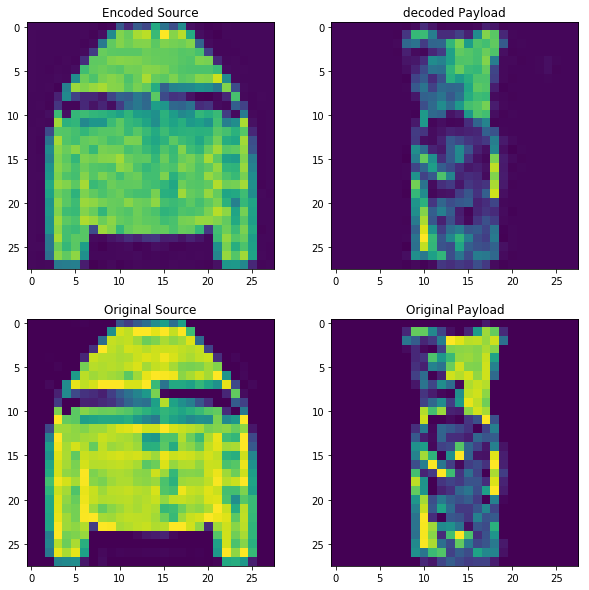

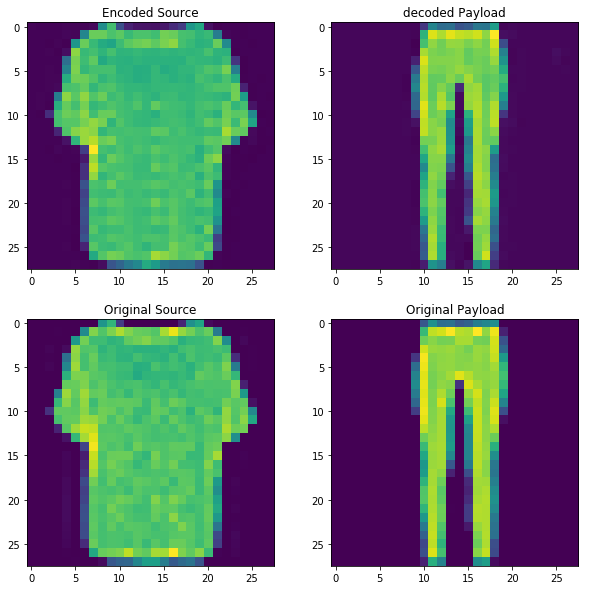

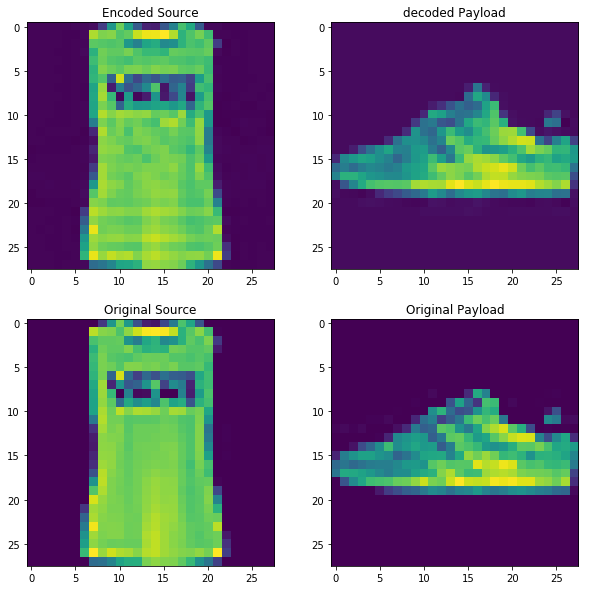

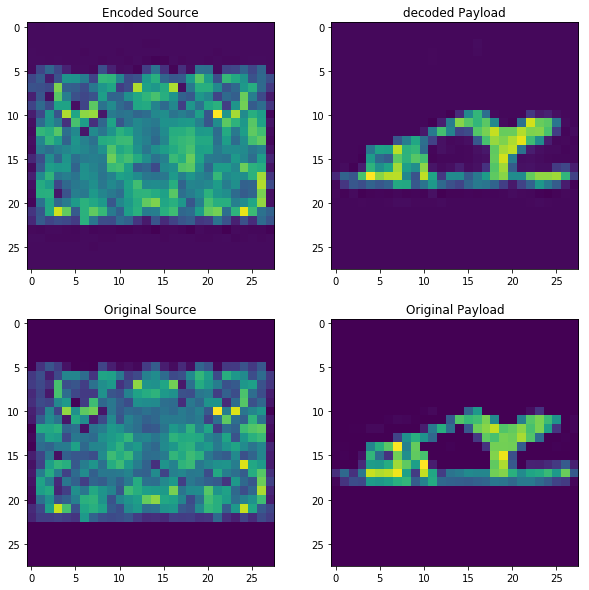

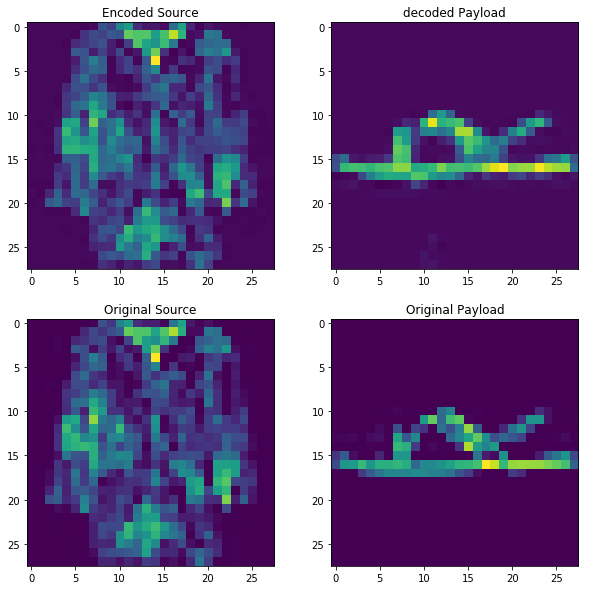

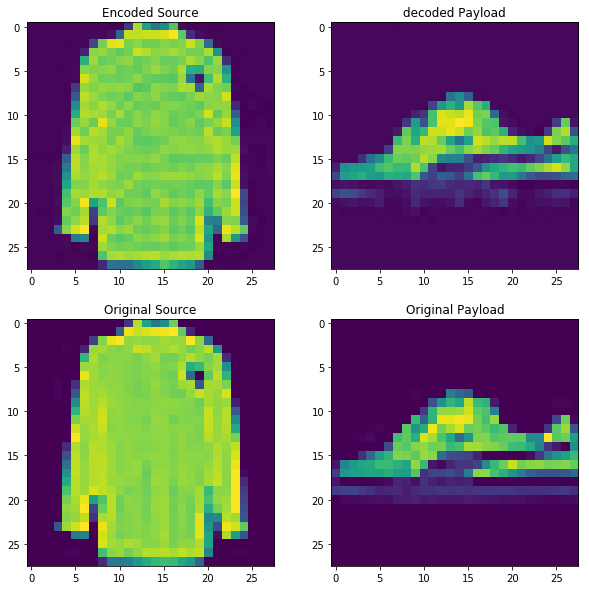

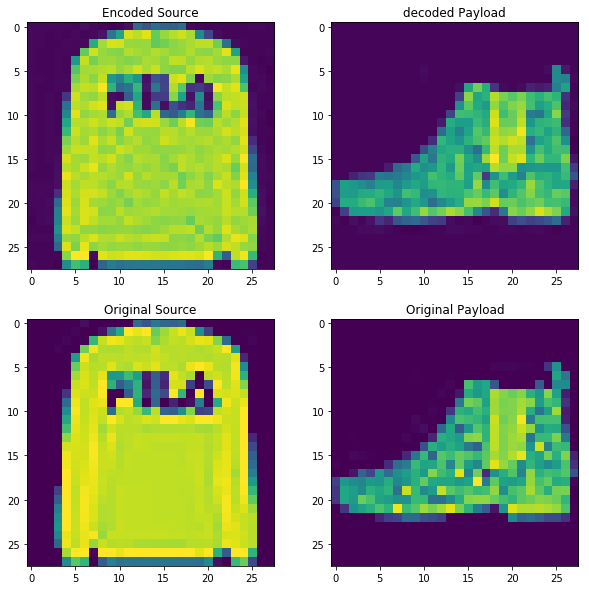

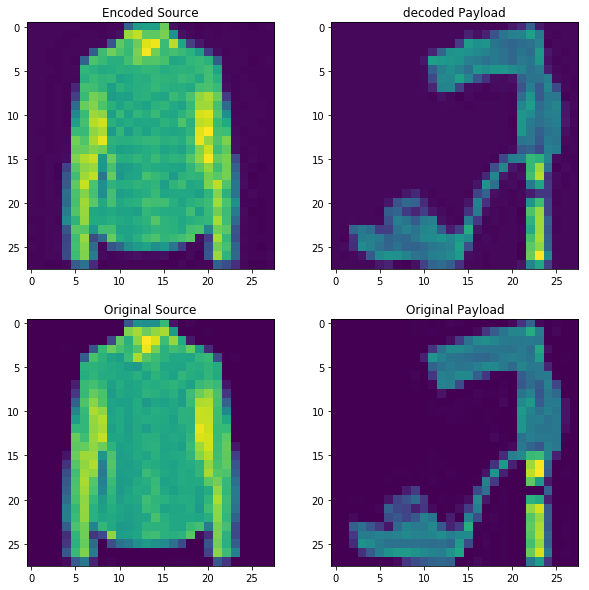

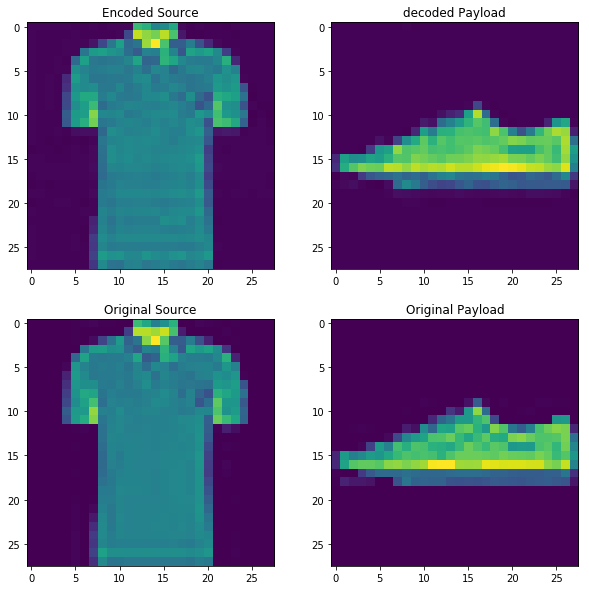

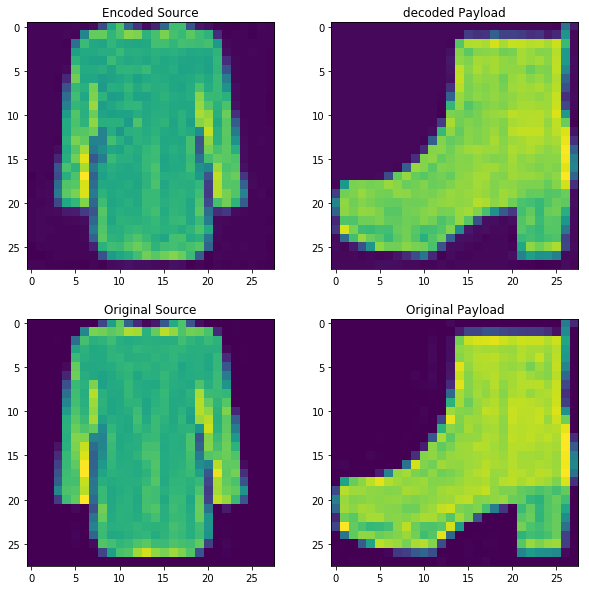

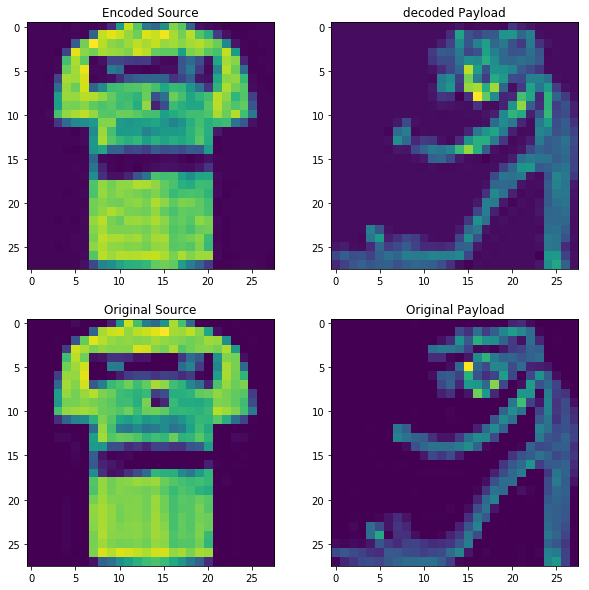

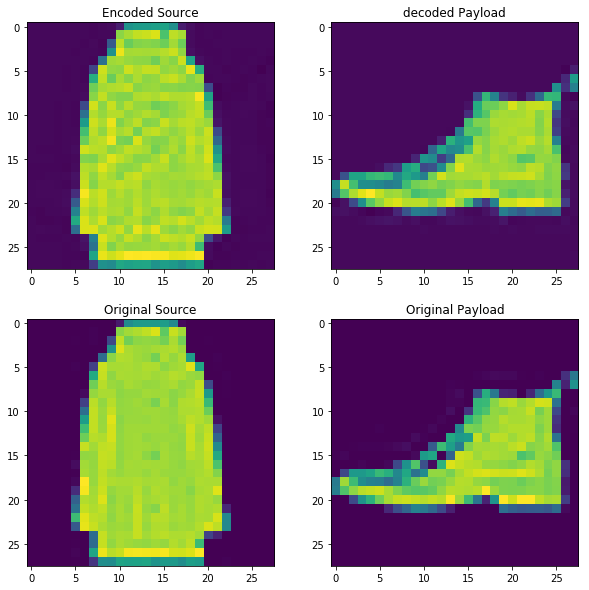

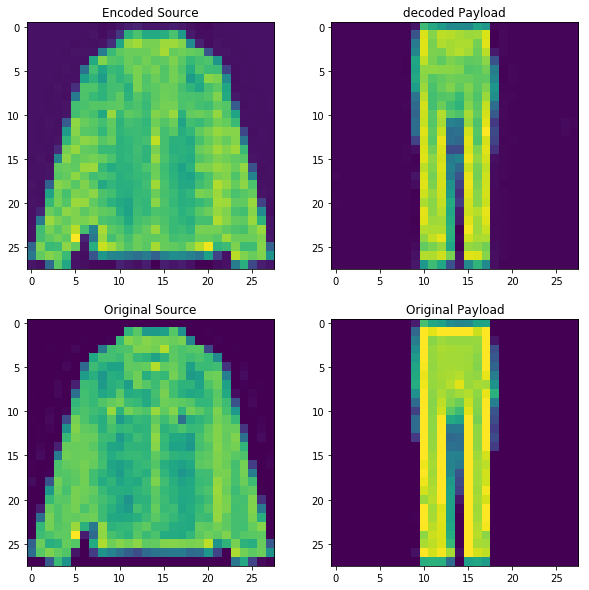

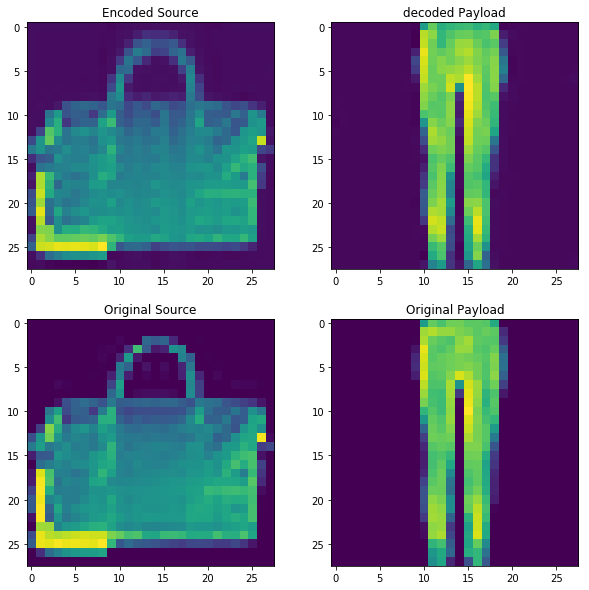

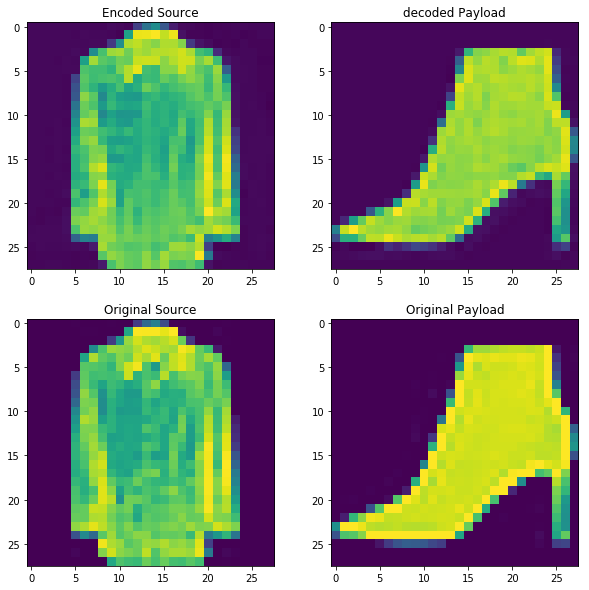

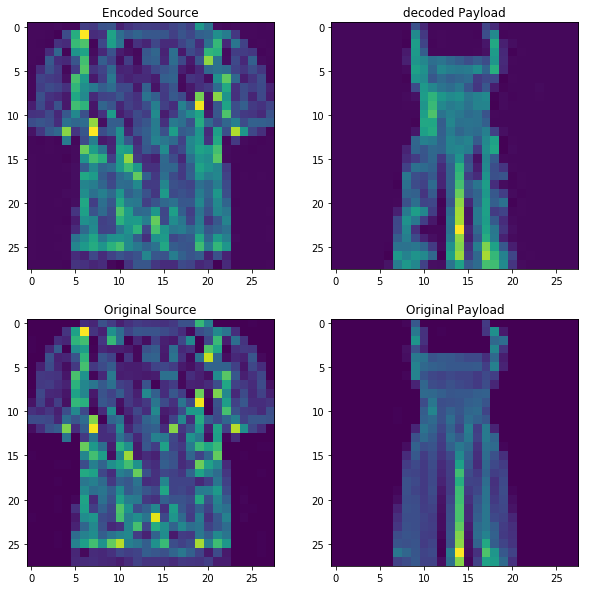

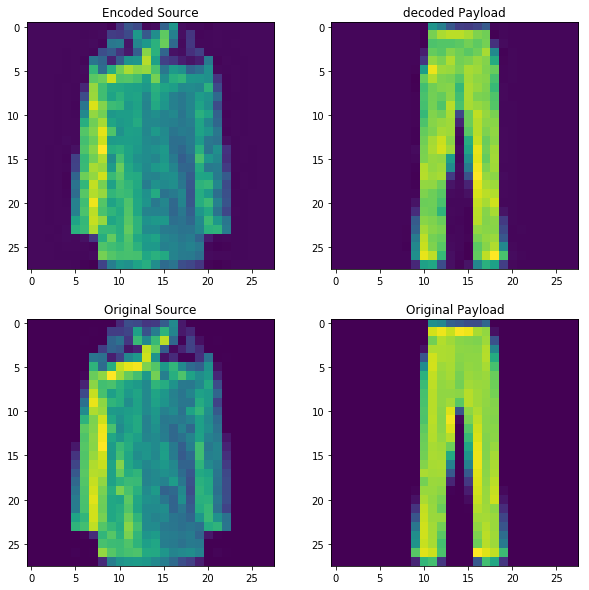

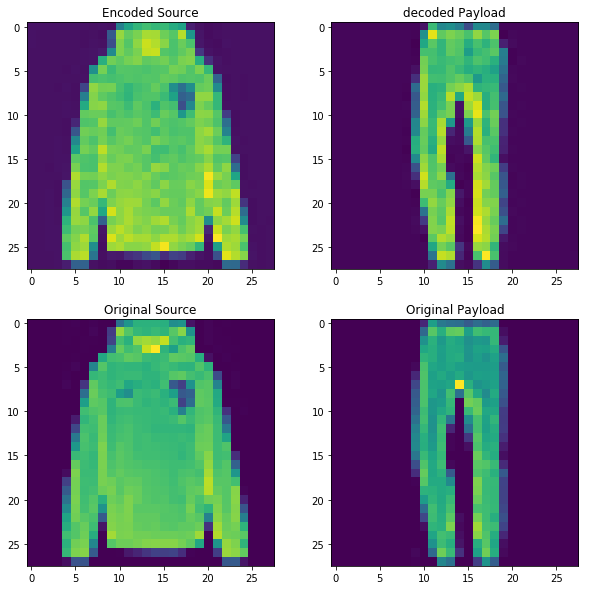

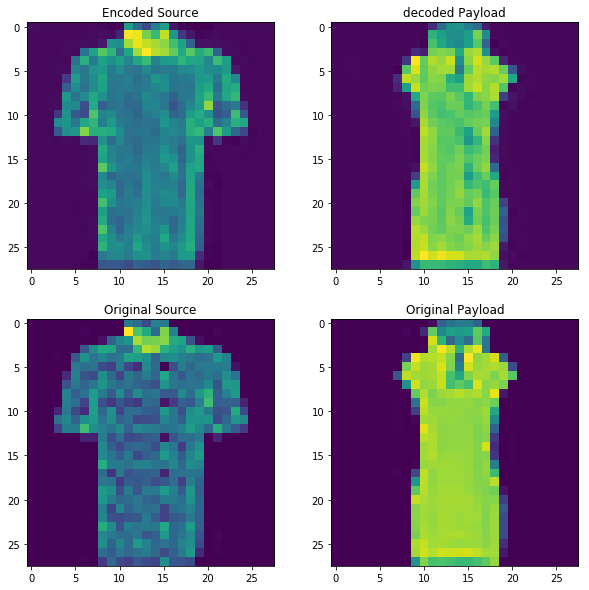

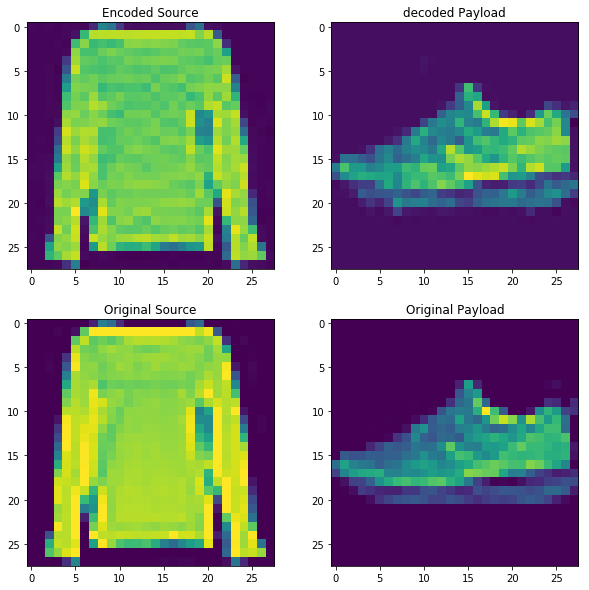

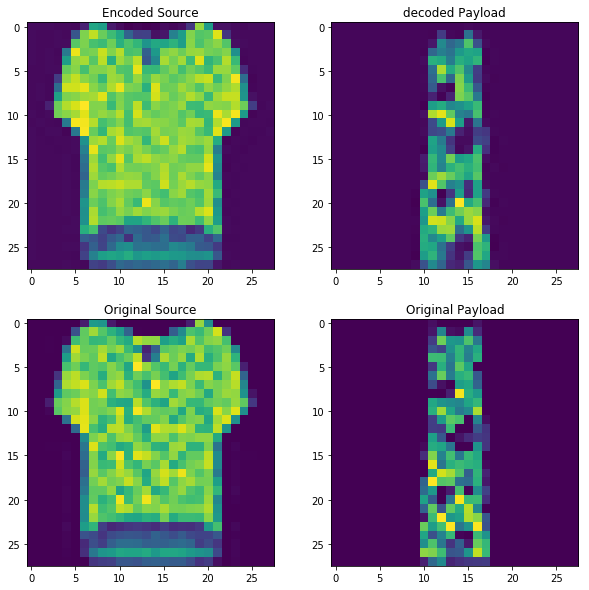

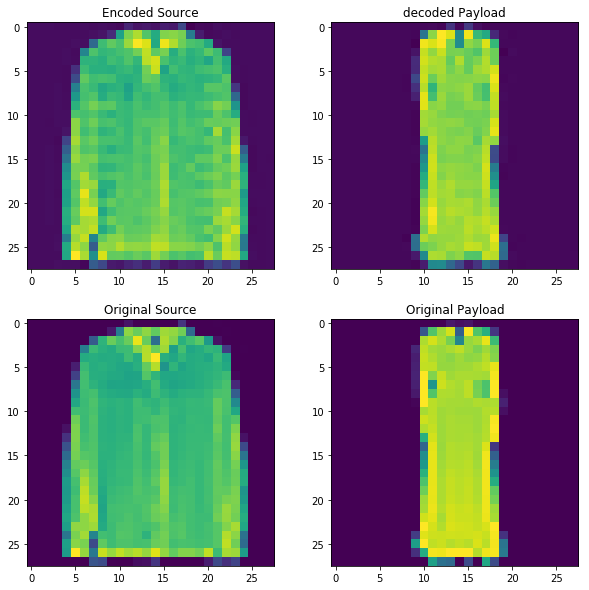

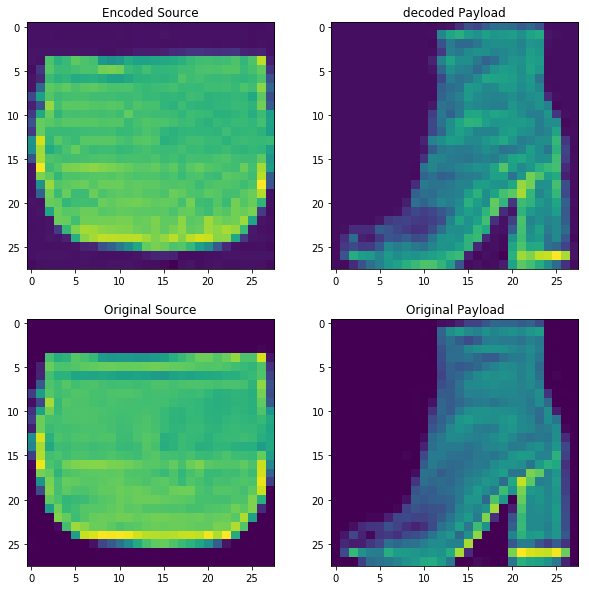

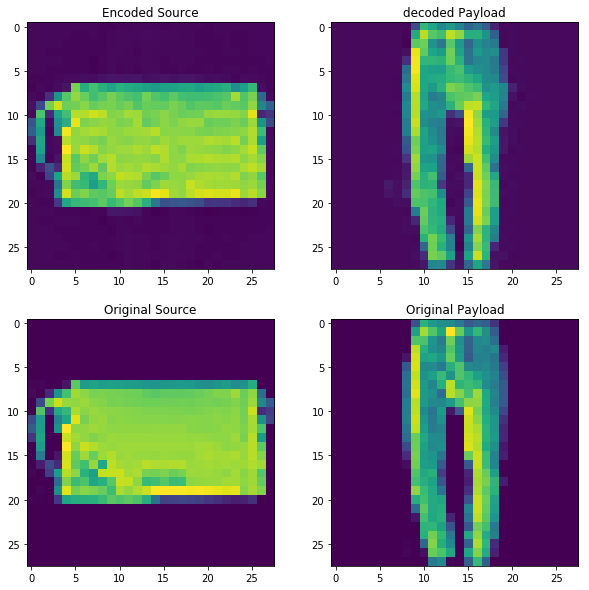

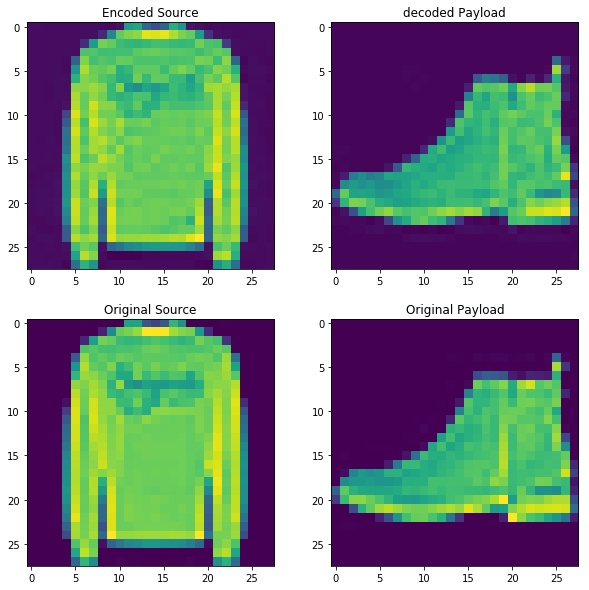

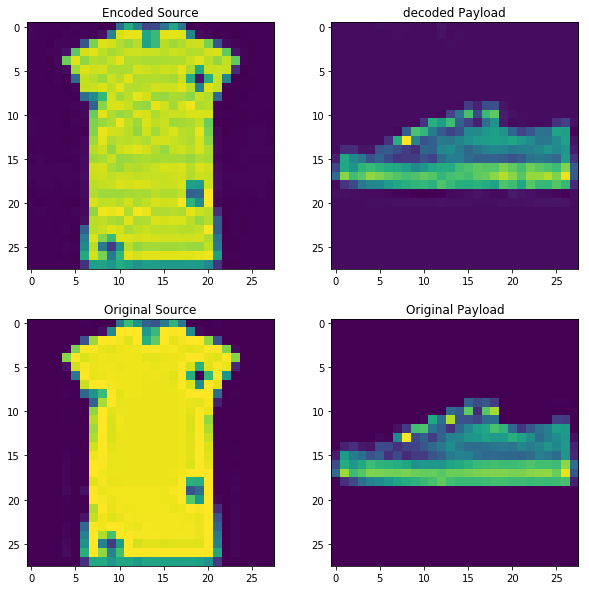

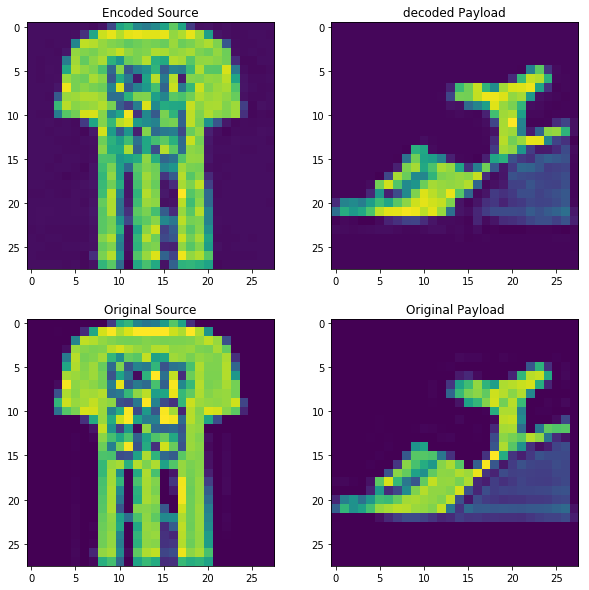

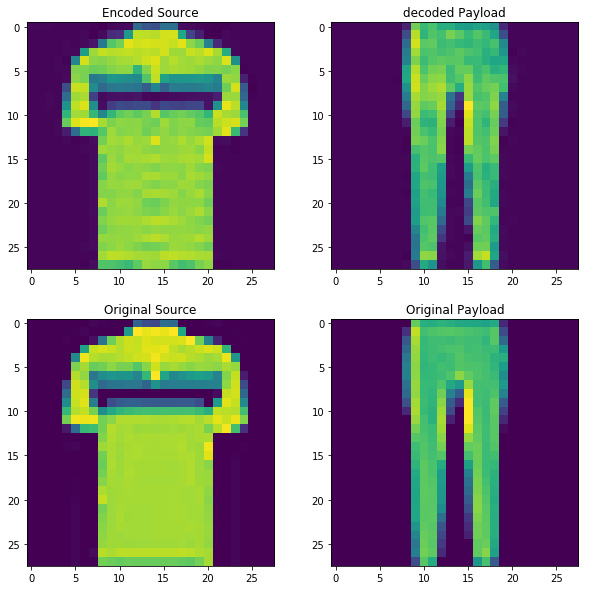

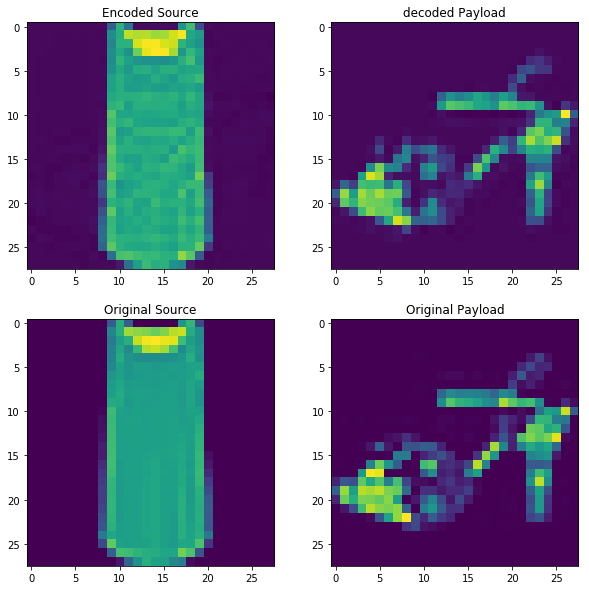

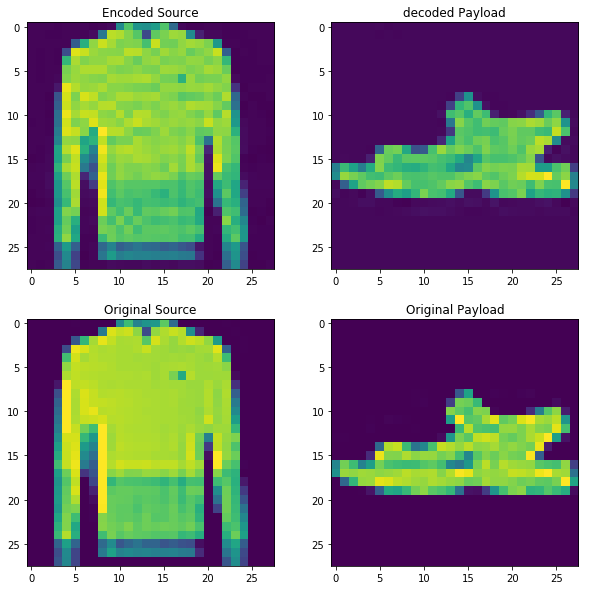

In [21]:
index = 20
for index in range(30):
    eimage = e.numpy().squeeze(1)[index]
    dimage = d.numpy().squeeze(1)[index]

    sourceimage, payloadimage = ss.numpy().squeeze(1)[index], pp.numpy().squeeze(1)[index]
    plt.figure(figsize=(10,10))
    plt.subplot(2, 2, 1)
    plt.title('Encoded Source')
    plt.imshow(eimage)
    plt.subplot(2, 2, 2)
    plt.title('decoded Payload')
    plt.imshow(dimage)

    plt.subplot(2, 2, 3)
    plt.title('Original Source')
    plt.imshow(sourceimage)
    plt.subplot(2, 2, 4)
    plt.title('Original Payload')
    plt.imshow(payloadimage)
    
    plt.show()

# Calculating PSNR Value on validation batch

In [31]:
encoded_psnr, decoded_psnr = [], []
for index in range(30):
    eimage = e.numpy().squeeze(1)[index]
    dimage = d.numpy().squeeze(1)[index]

    sourceimage, payloadimage = ss.numpy().squeeze(1)[index], pp.numpy().squeeze(1)[index]

    encoded_psnr.append(psnr(sourceimage, eimage))
    decoded_psnr.append(psnr(payloadimage, dimage))

print('Encoder PSNR: {}, Decoder PSNR: {}'.format(np.mean(encoded_psnr), np.mean(decoded_psnr)))

Encoder PSNR: 29.911241332115928, Decoder PSNR: 28.146133814704463


# Running model on test set

In [18]:
test_loss = 0.
model.eval()
with torch.no_grad():
    for idx in tqdm(range(int(len(source_val) / 60))):
        s, p = source_test[idx*60: (idx * 60) + 60], payload_test[idx*60: (idx * 60) + 60]
        s, p = torch.from_numpy(s).unsqueeze(1).float().cuda(), torch.from_numpy(p).unsqueeze(1).float().cuda()

        e_out, d_out = model.forward((s, p))

        e_loss = metric(e_out.squeeze(1).view((-1, 28 * 28)), s.squeeze(1).view((-1, 28 * 28)))
        d_loss = metric(d_out.squeeze(1).view((-1, 28 * 28)), p.squeeze(1).view((-1, 28 * 28)))
        loss = e_loss + d_loss

        test_loss += loss

    print('Test Loss: {}'.format(test_loss /int(len(source_test) / 60)))

100%|██████████| 50/50 [00:00<00:00, 198.94it/s]

Test Loss: 12.428180694580078
